In [3]:
import pandas as pd
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import classification_report
import nltk
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')



# Read the Data from the Given excel file.
df = pd.read_csv('/content/Twitter_Data.csv')

# Change our dependent variable to categorical.
df['category'] = df['category'].map({0: 'Neutral', -1: 'Negative', 1: 'Positive'})

# Do Missing value analysis and drop all null/missing values
df.dropna(inplace=True)

# Do text cleaning.
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char == ' '])
    words = word_tokenize(text)
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df['clean_text'] = df['clean_text'].apply(clean_text)

# Create a new column and find the length of each sentence
df['sentence_length'] = df['clean_text'].apply(lambda x: len(x.split()))

# Split data into dependent(X) and independent(y) dataframe
X = df['clean_text']
y = df['category']

# Do one-hot encoding for each sentence
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)
X_seq = tokenizer.texts_to_sequences(X)
X_padded = pad_sequences(X_seq, padding='pre')

# Build an LSTM model
vocab_size = len(tokenizer.word_index) + 1
max_length = X_padded.shape[1]

model = Sequential([
    Embedding(vocab_size, 100, input_length=max_length),
    LSTM(100),
    Dense(3, activation='softmax')
])

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Do dummy variable creation for the dependent variable
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = pd.get_dummies(y_encoded).values

# split the data into tests and train
X_train, X_test, y_train, y_test = train_test_split(X_padded, y_categorical, test_size=0.2, random_state=42)

# Train new model
model.fit(X_train, y_train, epochs=5, batch_size=64, validation_data=(X_test, y_test))

# Normalize the prediction
y_pred = model.predict(X_test)
y_pred_norm = np.argmax(y_pred, axis=1)

# Measure performance metrics and accuracy
print(classification_report(np.argmax(y_test, axis=1), y_pred_norm))


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Epoch 1/5
825/825 [==============================] - 44s 50ms/step - loss: 0.5118 - accuracy: 0.8028 - val_loss: 0.3544 - val_accuracy: 0.8861
Epoch 2/5
825/825 [==============================] - 13s 16ms/step - loss: 0.2472 - accuracy: 0.9212 - val_loss: 0.3627 - val_accuracy: 0.8836
Epoch 3/5
825/825 [==============================] - 8s 10ms/step - loss: 0.1664 - accuracy: 0.9489 - val_loss: 0.4314 - val_accuracy: 0.8660
Epoch 4/5
825/825 [==============================] - 8s 10ms/step - loss: 0.1172 - accuracy: 0.9628 - val_loss: 0.4739 - val_accuracy: 0.8666
Epoch 5/5
413/413 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.78      0.76      0.77      2863
           1       0.89      0.86      0.88      4481
           2       0.85      0.89      0.87      5847

    accuracy                           0.85     13191
   macro avg       0.84      0.84      0.84     13191
weighted avg       0.85      0.85      

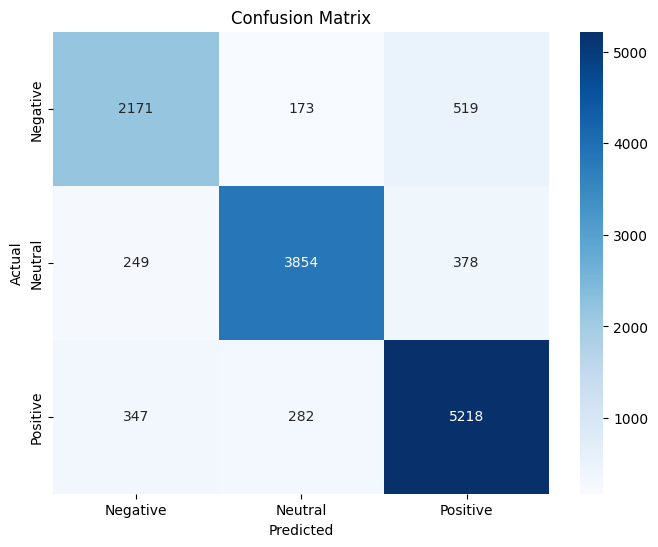

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Create confusion matrix
conf_mat = confusion_matrix(np.argmax(y_test, axis=1), y_pred_norm)

# Create a heatmap for the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()
